In [2]:
print("test")

test


In [3]:
import sys

class SuppressDataLoaderError:
    def __init__(self, original_stderr):
        self.original_stderr = original_stderr

    def write(self, data):
        # 특정 에러 문구가 포함된 경우 출력하지 않음
        if "Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__" in data:
            return
        if "AssertionError: can only test a child process" in data:
            return
        self.original_stderr.write(data)

    def flush(self):
        self.original_stderr.flush()

# stderr를 직접 정의한 필터로 교체
sys.stderr = SuppressDataLoaderError(sys.stderr)

# 하이브리드 추천 시스템 (Wide & Deep)

This notebook implements a Wide & Deep architecture for book rating prediction.
주요 구성:
- **Wide Component**: 사용자/아이템 임베딩 및 범주형 특성 사용
- **Deep Component**: BERT 기반 텍스트 임베딩 (제목+요약) 및 CNN 기반 이미지 특성 사용


In [4]:
import os
import gc
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set seed for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [5]:
# Load Data
DATA_PATH = '../data/'
books = pd.read_csv(os.path.join(DATA_PATH, 'books.csv'))
users = pd.read_csv(os.path.join(DATA_PATH, 'users.csv'))
train_ratings = pd.read_csv(os.path.join(DATA_PATH, 'train_ratings.csv'))
test_ratings = pd.read_csv(os.path.join(DATA_PATH, 'test_ratings.csv'))
sub = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

In [6]:
# # 데이터 노이즈 추가
# noise_std = 0.2
# noise = np.random.normal(loc=0, scale=noise_std, size=len(train_ratings))

# # rating에 노이즈를 더함
# train_ratings['rating'] = train_ratings['rating'] + noise

# # 평점 범위를 벗어나지 않도록 제한
# train_ratings['rating'] = train_ratings['rating'].clip(0, 10)

In [7]:
print(f"Books: {books.shape}")
print(f"Users: {users.shape}")
print(f"Train Ratings: {train_ratings.shape}")
print(f"Test Ratings: {test_ratings.shape}")

Books: (149570, 10)
Users: (68092, 3)
Train Ratings: (306795, 3)
Test Ratings: (76699, 3)


In [8]:
# 1. 데이터 전처리 및 특성 공학

# 1. 평점 데이터와 사용자/도서 데이터 병합
# 추후 분리를 위해 학습/테스트 플래그 추가
train_ratings['is_train'] = 1
test_ratings['is_train'] = 0
test_ratings['rating'] = 0 # Dummy value

all_ratings = pd.concat([train_ratings, test_ratings], axis=0).reset_index(drop=True)

# Merge
df = all_ratings.merge(users, on='user_id', how='left')
df = df.merge(books, on='isbn', how='left')

print(f"Merged Data Shape: {df.shape}")

# 2. ID 및 범주형 변수 인코딩

# 사용자 ID 인코딩
user_encoder = LabelEncoder()
df['user_idx'] = user_encoder.fit_transform(df['user_id'].astype(str))
num_users = len(user_encoder.classes_)
print(f"Num Users: {num_users}")

# ISBN (도서 ID) 인코딩
item_encoder = LabelEncoder()
df['item_idx'] = item_encoder.fit_transform(df['isbn'].astype(str))
num_items = len(item_encoder.classes_)
print(f"Num Items: {num_items}")

# 위치 정보: 국가 및 주(State) 추출
def process_location(loc):
    if pd.isna(loc):
        return 'unknown', 'unknown'
    parts = [x.strip() for x in loc.split(',')]
    country = parts[-1] if len(parts) > 0 else 'unknown'
    state = parts[-2] if len(parts) > 1 else 'unknown'
    return state, country

df['state'], df['country'] = zip(*df['location'].apply(process_location))

# Encode Location
state_encoder = LabelEncoder()
country_encoder = LabelEncoder()
df['state_idx'] = state_encoder.fit_transform(df['state'])
df['country_idx'] = country_encoder.fit_transform(df['country'])
num_states = len(state_encoder.classes_)
num_countries = len(country_encoder.classes_)

# Category
def process_category(cat):
    if pd.isna(cat):
        return 'unknown'
    # It looks like "['Category']", remove brackets and quotes
    clean = cat.strip("[]").replace("'", "").replace('"', "")
    if not clean:
        return 'unknown'
    # Take first if multiple
    return clean.split(',')[0].strip()

df['category_clean'] = df['category'].apply(process_category)
cat_encoder = LabelEncoder()
df['category_idx'] = cat_encoder.fit_transform(df['category_clean'])
num_categories = len(cat_encoder.classes_)

# 저자 및 출판사 처리 (희귀 값 처리)
def encode_with_threshold(series, threshold=5):
    counts = series.value_counts()
    valid = counts[counts >= threshold].index
    mapping = {v: i+1 for i, v in enumerate(valid)} # 0 for unknown
    return series.map(mapping).fillna(0).astype(int), len(valid) + 1

df['book_author'] = df['book_author'].fillna('unknown')
df['publisher'] = df['publisher'].fillna('unknown')

df['author_idx'], num_authors = encode_with_threshold(df['book_author'])
df['publisher_idx'], num_publishers = encode_with_threshold(df['publisher'])

# 출판 연도 전처리
df['year_of_publication'] = pd.to_numeric(df['year_of_publication'], errors='coerce').fillna(2000).astype(int)
# 이상치 연도 제외
df['year_of_publication'] = df['year_of_publication'].clip(1900, 2025)
# 연도 버킷화 (단순 오프셋)
min_year = df['year_of_publication'].min()
df['year_idx'] = df['year_of_publication'] - min_year
num_years = df['year_idx'].max() + 1

# 나이 결측치 및 구간화
df['age'] = df['age'].fillna(-1)
def bin_age(age):
    if age < 0: return 0 # Unknown
    if age < 10: return 1
    if age < 20: return 2
    if age < 30: return 3
    if age < 40: return 4
    if age < 50: return 5
    if age < 60: return 6
    if age < 70: return 7
    return 8

df['age_idx'] = df['age'].apply(bin_age)
num_ages = 9

print(f"Feature dims: Users={num_users}, Items={num_items}, States={num_states}, Cats={num_categories}, Auth={num_authors}")


Merged Data Shape: (383494, 15)
Num Users: 68069
Num Items: 149570
Feature dims: Users=68069, Items=149570, States=1534, Cats=4027, Auth=10064


In [9]:
# 3. 비정형 데이터 전처리

# 텍스트: 제목과 요약 결합
df['book_title'] = df['book_title'].fillna('')
df['summary'] = df['summary'].fillna('')
df['text_combined'] = "[TITLE] " + df['book_title'] + " [SEP] " + df['summary']

# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
MAX_LEN = 128

# 이미지 경로 설정
IMG_DIR = '../data/images' # Update if actual path is different
def get_img_path(isbn):
    return os.path.join(IMG_DIR, f"{isbn}.jpg")

df['img_path'] = df['isbn'].apply(get_img_path)


In [10]:
from torchvision import transforms

# 이미지 전처리 정의 (크기 조정 및 정규화)
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class HybridDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, img_transforms):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.img_transforms = img_transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Wide 특성 (정형 데이터)
        user_idx = torch.tensor(row['user_idx'], dtype=torch.long)
        item_idx = torch.tensor(row['item_idx'], dtype=torch.long)
        state_idx = torch.tensor(row['state_idx'], dtype=torch.long)
        country_idx = torch.tensor(row['country_idx'], dtype=torch.long)
        category_idx = torch.tensor(row['category_idx'], dtype=torch.long)
        author_idx = torch.tensor(row['author_idx'], dtype=torch.long)
        publisher_idx = torch.tensor(row['publisher_idx'], dtype=torch.long)
        year_idx = torch.tensor(row['year_idx'], dtype=torch.long)
        age_idx = torch.tensor(row['age_idx'], dtype=torch.long)
        
        # 타겟 (평점)
        rating = torch.tensor(row['rating'], dtype=torch.float)
        
        # 텍스트 데이터 (BERT 입력)
        text = str(row['text_combined'])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        
        # 이미지 데이터
        img_path = row['img_path']
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.img_transforms(image)
        except Exception:
            image = torch.zeros((3, 224, 224))
            
        return {
            'user_idx': user_idx,
            'item_idx': item_idx,
            'state_idx': state_idx,
            'country_idx': country_idx,
            'category_idx': category_idx,
            'author_idx': author_idx,
            'publisher_idx': publisher_idx,
            'year_idx': year_idx,
            'age_idx': age_idx,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'rating': rating
        }


In [11]:
class WideAndDeepModel(nn.Module):
    def __init__(self, num_users, num_items, num_states, num_countries, 
                 num_categories, num_authors, num_publishers, num_years, num_ages,
                 embedding_dim=32):
        super(WideAndDeepModel, self).__init__()
        
        # --- Wide Tower (임베딩 레이어) ---
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        self.state_emb = nn.Embedding(num_states, embedding_dim // 2)
        self.country_emb = nn.Embedding(num_countries, embedding_dim // 2)
        self.cat_emb = nn.Embedding(num_categories, embedding_dim // 2)
        self.auth_emb = nn.Embedding(num_authors, embedding_dim // 2)
        self.pub_emb = nn.Embedding(num_publishers, embedding_dim // 2)
        self.year_emb = nn.Embedding(num_years, embedding_dim // 2)
        self.age_emb = nn.Embedding(num_ages, embedding_dim // 2)
        
        # 임베딩 레이어 초기화
        nn.init.normal_(self.user_emb.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.item_emb.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.state_emb.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.country_emb.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.cat_emb.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.auth_emb.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.pub_emb.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.year_emb.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.age_emb.weight, mean=0.0, std=0.01)
        
        # Calculate Wide Output Dim
        self.wide_dim = (embedding_dim * 2) + (embedding_dim // 2 * 7)
        
        # --- Deep Tower (텍스트 처리) ---
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased', attn_implementation='eager')
        self.text_proj = nn.Linear(768, 64) # Project BERT [CLS] to smaller dim
        
        # --- Deep Tower (이미지 처리) ---
        self.image_cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        self.img_proj = nn.Linear(32, 32)
        
        # --- 결합 (Fusion) ---
        fusion_dim = self.wide_dim + 64 + 32
        
        self.mlp = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
        
        # 출력 바이어스를 전체 평균(~7.5)으로 초기화 (분포 보정)
        self.mlp[-1].bias.data.fill_(7.5)
        
    def forward(self, batch):
        # Wide
        u_emb = self.user_emb(batch['user_idx'])
        i_emb = self.item_emb(batch['item_idx'])
        st_emb = self.state_emb(batch['state_idx'])
        co_emb = self.country_emb(batch['country_idx'])
        ca_emb = self.cat_emb(batch['category_idx'])
        au_emb = self.auth_emb(batch['author_idx'])
        pu_emb = self.pub_emb(batch['publisher_idx'])
        ye_emb = self.year_emb(batch['year_idx'])
        ag_emb = self.age_emb(batch['age_idx'])
        
        wide_vec = torch.cat([u_emb, i_emb, st_emb, co_emb, ca_emb, au_emb, pu_emb, ye_emb, ag_emb], dim=1)
        
        # Text
        # BERT forward
        outputs = self.bert(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        cls_token = outputs.last_hidden_state[:, 0, :] # [CLS]
        text_vec = self.text_proj(cls_token) # 768 -> 64
        
        # 이미지 데이터
        img_vec = self.image_cnn(batch['image'])
        img_vec = self.img_proj(img_vec)
        
        # Fusion
        fused = torch.cat([wide_vec, text_vec, img_vec], dim=1)
        
        # 최종 출력
        rating = self.mlp(fused)
        return rating.squeeze()


In [12]:
# 4. 학습 설정

# 학습 데이터 분할
train_df = df[df['is_train'] == 1].reset_index(drop=True)
test_df = df[df['is_train'] == 0].reset_index(drop=True)

X_train, X_val = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Train Size: {len(X_train)}, Val Size: {len(X_val)}")

# 데이터셋 생성
train_ds = HybridDataset(X_train, tokenizer, MAX_LEN, img_transforms)
val_ds = HybridDataset(X_val, tokenizer, MAX_LEN, img_transforms)

# 데이터로더 생성
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


Train Size: 276115, Val Size: 30680


In [13]:
# 모델 초기화
model = WideAndDeepModel(
    num_users=num_users, num_items=num_items, num_states=num_states, 
    num_countries=num_countries, num_categories=num_categories, 
    num_authors=num_authors + 1, num_publishers=num_publishers + 1, 
    num_years=num_years, num_ages=num_ages,
    embedding_dim=32
)
model = model.to(device)

In [14]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)

scaler = GradScaler() # AMP

EPOCHS = 3
best_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    start_time = time.time()
    total_loss = 0
    
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        for k in batch:
            batch[k] = batch[k].to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(batch)
            loss = criterion(outputs, batch['rating'])
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())
    
    avg_train_loss = total_loss / len(train_loader)
    
    # 검증
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in val_loader:
            for k in batch:
                batch[k] = batch[k].to(device, non_blocking=True)
        
            with autocast():
                outputs = model(batch)
                loss = criterion(outputs, batch['rating'])
            
            val_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(batch['rating'].cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val RMSE: {val_rmse:.4f} | Time: {time.time() - start_time:.2f}s")
    
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved Best Model!")


  0%|          | 0/4315 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 5.2494 | Val Loss: 4.7759 | Val RMSE: 2.1851 | Time: 681.51s
Saved Best Model!


  0%|          | 0/4315 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 4.1995 | Val Loss: 4.6916 | Val RMSE: 2.1657 | Time: 681.03s
Saved Best Model!


  0%|          | 0/4315 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 3.4444 | Val Loss: 4.9202 | Val RMSE: 2.2179 | Time: 681.39s


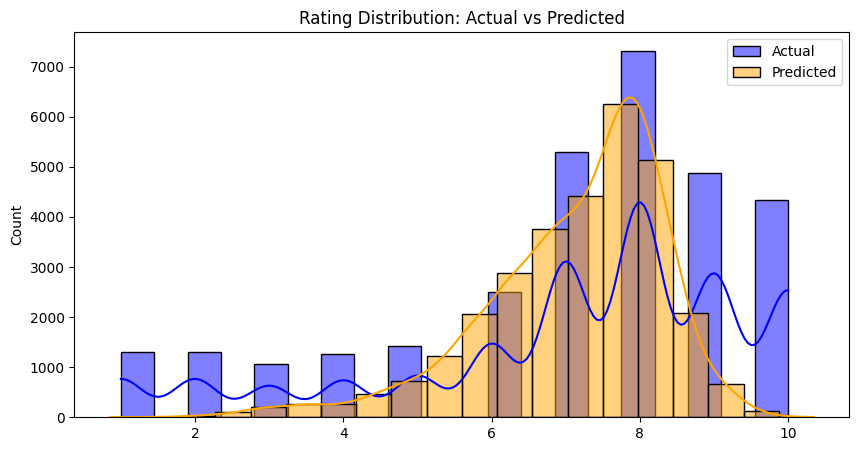

Actual Mean: 7.0765
Predicted Mean: 7.1367


In [15]:
# 5. 평가 및 시각화

# 최적 모델 로드
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 검증 세트 예측
val_preds = []
val_targets = []

with torch.no_grad():
    for batch in val_loader:
        for k in batch:
            batch[k] = batch[k].to(device, non_blocking=True)
        with autocast():
            outputs = model(batch)
        val_preds.extend(outputs.cpu().numpy())
        val_targets.extend(batch['rating'].cpu().numpy())

val_preds = np.array(val_preds)
val_targets = np.array(val_targets)

# 1. 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(val_targets, color='blue', label='Actual', kde=True, bins=20)
sns.histplot(val_preds, color='orange', label='Predicted', kde=True, bins=20)
plt.title('Rating Distribution: Actual vs Predicted')
plt.legend()
plt.show()

# 평균 확인
print(f"Actual Mean: {val_targets.mean():.4f}")
print(f"Predicted Mean: {val_preds.mean():.4f}")


Extracted features shape: (2048, 272)


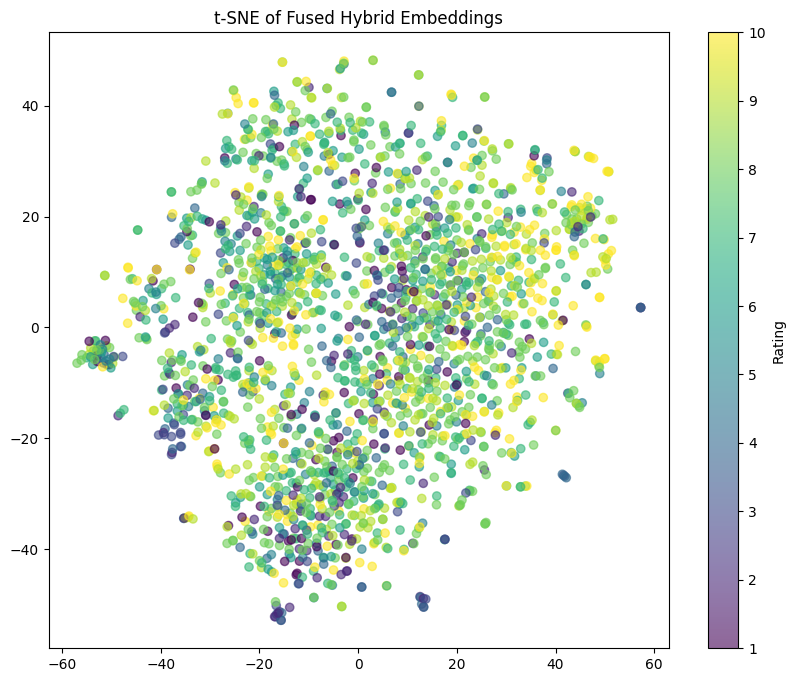

In [16]:
# 2. 임베딩 벡터 t-SNE 시각화

from sklearn.manifold import TSNE

# 검증 세트에서 임베딩 추출
fused_vectors = []
labels = []

def hook_fn(module, input, output):
    fused_vectors.append(input[0].detach().cpu().numpy())

# Register hook on model.mlp
hook = model.mlp.register_forward_hook(hook_fn)

model.eval()
count = 0
MAX_SAMPLES = 2000

with torch.no_grad():
    for batch in val_loader:
        for k in batch:
            batch[k] = batch[k].to(device, non_blocking=True)
            
        with autocast():
            _ = model(batch)
            
        labels.extend(batch['rating'].cpu().numpy())
        count += batch['rating'].size(0)
        if count >= MAX_SAMPLES:
            break

hook.remove()

# 추출된 벡터 처리
fused_vectors = np.concatenate(fused_vectors, axis=0)[:len(labels)]
labels = np.array(labels)

print(f"Extracted features shape: {fused_vectors.shape}")

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_results = tsne.fit_transform(fused_vectors)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Rating')
plt.title('t-SNE of Fused Hybrid Embeddings')
plt.show()

In [17]:
# 6. 제출 파일 생성 (Test 예측 및 저장)
import os
from datetime import datetime

# 테스트 데이터셋 준비 (is_train == 0)
test_df = df[df['is_train'] == 0].reset_index(drop=True)
test_ds = HybridDataset(test_df, tokenizer, MAX_LEN, img_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Test Set Size: {len(test_df)}")

# 모델 평가 모드 전환
model.eval()
test_preds = []

print("Start Inference on Test Set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Inference"):
        for k in batch:
            batch[k] = batch[k].to(device, non_blocking=True)
        
        with autocast():
            outputs = model(batch)
        
        test_preds.extend(outputs.cpu().numpy())

# 결과값 범위 제한 (Optional: 0~10)
test_preds = np.clip(test_preds, 0, 10)

# 제출 파일 생성
submission_path = '../data/sample_submission.csv'
if os.path.exists(submission_path):
    submission = pd.read_csv(submission_path)
    submission['rating'] = test_preds
else:
    print("Warning: sample_submission.csv not found. Creating dataframe manually.")
    submission = pd.DataFrame({
        'user_id': test_df['user_id'],
        'isbn': test_df['isbn'],
        'rating': test_preds
    })

# 저장 디렉토리 생성
output_dir = './output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 파일 저장
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_filename = f'Hybrid_{timestamp}.csv'
save_path = os.path.join(output_dir, save_filename)

submission.to_csv(save_path, index=False)
print(f"Prediction saved to: {save_path}")


Test Set Size: 76699
Start Inference on Test Set...


Inference:   0%|          | 0/1199 [00:00<?, ?it/s]

Prediction saved to: ./output/Hybrid_20251212_032028.csv


In [18]:
torch.save(model.state_dict(), f'./model_save/best_model_{timestamp}.pth')